In [4]:
#!/usr/bin/env python
"""
Demo pipeline for processing voltage imaging data. The processing pipeline
includes motion correction, memory mapping, segmentation, denoising and source
extraction. The demo shows how to construct the params, MotionCorrect and VOLPY 
objects and call the relevant functions. See inside for detail.
Dataset courtesy of Karel Svoboda Lab (Janelia Research Campus).
author: @caichangjia
"""
import cv2
import glob
import h5py
import logging
import matplotlib.pyplot as plt
import numpy as np
import os



#os.environ["MESMERIZE_N_PROCESSES"] = '40'

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.paths import caiman_datadir
from caiman.source_extraction.volpy import utils
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.summary_images import local_correlations_movie_offline
from caiman.summary_images import mean_image
from caiman.utils.utils import download_demo, download_model

# %%
# Set up the logger (optional); change this if you like.
# You can log to a file using the filename parameter, or make the output more
# or less verbose by setting level to logging.DEBUG, logging.INFO,
# logging.WARNING, or logging.ERROR
logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]" \
                    "[%(process)d] %(message)s",
                    level=logging.INFO)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# %%
def main():
    pass  # For compatibility between running under Spyder and the CLI

    # %%  Load demo movie and ROIs
    #fnames = download_demo('demo_voltage_imaging.hdf5', 'volpy')  # file path to movie file (will download if not present)
    #path_ROIs = download_demo('demo_voltage_imaging_ROIs.hdf5', 'volpy')  # file path to ROIs file (will download if not present)
    
    fnames = r"C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5.tif"
    file_dir = os.path.split(fnames)[0]
    
#%% dataset dependent parameters
    # dataset dependent parameters
    fr = 408                                        # sample rate of the movie

    # motion correction parameters
    pw_rigid = False                                # flag for pw-rigid motion correction
    gSig_filt = (3, 3)                              # size of filter, in general gSig (see below),
                                                    # change this one if algorithm does not work
    max_shifts = (5, 5)                             # maximum allowed rigid shift
    strides = (48, 48)                              # start a new patch for pw-rigid motion correction every x pixels
    overlaps = (24, 24)                             # overlap between pathes (size of patch strides+overlaps)
    max_deviation_rigid = 3                         # maximum deviation allowed for patch with respect to rigid shifts
    border_nan = 'copy'

    opts_dict = {
        'fnames': fnames,
        'fr': fr,
        'pw_rigid': pw_rigid,
        'max_shifts': max_shifts,
        'gSig_filt': gSig_filt,
        'strides': strides,
        'overlaps': overlaps,
        'max_deviation_rigid': max_deviation_rigid,
        'border_nan': border_nan
    }

    opts = volparams(params_dict=opts_dict)

# %% play the movie (optional)
    # playing the movie using opencv. It requires loading the movie in memory.
    # To close the movie press q
    display_images = False

    if display_images:
        m_orig = cm.load(fnames)
        ds_ratio = 0.2
        moviehandle = m_orig.resize(1, 1, ds_ratio)
        moviehandle.play(q_max=99.5, fr=40, magnification=4)

# %% start a cluster for parallel processing
    c, dview, n_processes = cm.cluster.setup_cluster(
        backend='local', n_processes=50, single_thread=False)

    print("Motion COrrection")
# %%% MOTION CORRECTION
    # first we create a motion correction object with the specified parameters
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    # Run correction
    do_motion_correction = True
    if do_motion_correction:
        mc.motion_correct(save_movie=True)
    else: 
        mc_list = [file for file in os.listdir(file_dir) if 
                   (os.path.splitext(os.path.split(fnames)[-1])[0] in file and '.mmap' in file)]
        mc.mmap_file = [os.path.join(file_dir, mc_list[0])]
        print(f'reuse previously saved motion corrected file:{mc.mmap_file}')

# %% compare with original movie
    if display_images:
        m_orig = cm.load(fnames)
        m_rig = cm.load(mc.mmap_file)
        ds_ratio = 0.2
        moviehandle = cm.concatenate([m_orig.resize(1, 1, ds_ratio),
                                      m_rig.resize(1, 1, ds_ratio)], axis=2)
        moviehandle.play(fr=40, q_max=99.5, magnification=4)  # press q to exit

# %% MEMORY MAPPING
    do_memory_mapping = True
    if do_memory_mapping:
        border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0
        # you can include the boundaries of the FOV if you used the 'copy' option
        # during motion correction, although be careful about the components near
        # the boundaries
        
        # memory map the file in order 'C'
        fname_new = cm.save_memmap_join(mc.mmap_file, base_name='memmap_' + os.path.splitext(os.path.split(fnames)[-1])[0],
                                        add_to_mov=border_to_0, dview=dview)  # exclude border
    else: 
        mmap_list = [file for file in os.listdir(file_dir) if 
                     ('memmap_' + os.path.splitext(os.path.split(fnames)[-1])[0]) in file]
        fname_new = os.path.join(file_dir, mmap_list[0])
        print(f'reuse previously saved memory mapping file:{fname_new}')
    
    
    
    
    
    
   
    
# %% SEGMENTATION
    # create summary images
    img = mean_image(mc.mmap_file[0], window = 1000, dview=dview)
    img = (img-np.mean(img))/np.std(img)
    
    gaussian_blur = False        # Use gaussian blur when there is too much noise in the video
    Cn = local_correlations_movie_offline(mc.mmap_file[0], fr=fr, window=fr*4, 
                                          stride=fr*4, winSize_baseline=fr, 
                                          remove_baseline=True, gaussian_blur=gaussian_blur,
                                          dview=dview).max(axis=0)
    img_corr = (Cn-np.mean(Cn))/np.std(Cn)
    summary_images = np.stack([img, img, img_corr], axis=0).astype(np.float32)
    # save summary images which are used in the VolPy GUI
    cm.movie(summary_images).save(fnames[:-5] + '_summary_images.tif')
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(summary_images[0]); axs[1].imshow(summary_images[2])
    axs[0].set_title('mean image'); axs[1].set_title('corr image')

    #%% methods for segmentation
    methods_list = ['manual_annotation',       # manual annotations need prepared annotated datasets in the same format as demo_voltage_imaging_ROIs.hdf5 
                    'maskrcnn',                # Mask R-CNN is a convolutional neural network trained for detecting neurons in summary images
                    'gui_annotation']          # use VolPy GUI to correct outputs of Mask R-CNN or annotate new datasets 
                    
    #method = methods_list[1]
    method = 'maskrcnn'  
    if method == 'manual_annotation':                
        with h5py.File(path_ROIs, 'r') as fl:
            ROIs = fl['mov'][()]  

    elif method == 'maskrcnn':                 
        weights_path = download_model('mask_rcnn')    
        ROIs = utils.mrcnn_inference(img=summary_images.transpose([1, 2, 0]), size_range=[15, 100],
                                     weights_path=weights_path, display_result=True) # size parameter decides size range of masks to be selected
        cm.movie(ROIs).save(fnames[:-5] + '_mrcnn_ROIs.hdf5')

    elif method == 'gui_annotation':
        # run volpy_gui.py file in the caiman/source_extraction/volpy folder
        # or run the following in the ipython:  %run volpy_gui.py
        gui_ROIs =  caiman_datadir() + '/example_movies/volpy/gui_roi.hdf5'
        with h5py.File(gui_ROIs, 'r') as fl:
            ROIs = fl['mov'][()]

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(summary_images[0]); axs[1].imshow(ROIs.sum(0))
    axs[0].set_title('mean image'); axs[1].set_title('masks')
        
# %% restart cluster to clean up memory
    cm.stop_server(dview=dview)
    c, dview, n_processes = cm.cluster.setup_cluster(
        backend='local', n_processes=50, single_thread=False, maxtasksperchild=1)
    
    print("SEGMENT DONE!")
    
    
    
    
"""    
    
    
    
    

# %% parameters for trace denoising and spike extraction
    ROIs = ROIs                                   # region of interests
    index = list(range(len(ROIs)))                # index of neurons
    weights = None                                # if None, use ROIs for initialization; to reuse weights check reuse weights block 

    template_size = 0.02                          # half size of the window length for spike templates, default is 20 ms 
    context_size = 35                             # number of pixels surrounding the ROI to censor from the background PCA
    visualize_ROI = False                         # whether to visualize the region of interest inside the context region
    flip_signal = True                            # Important!! Flip signal or not, True for Voltron indicator, False for others
    hp_freq_pb = 1 / 3                            # parameter for high-pass filter to remove photobleaching
    clip = 100                                    # maximum number of spikes to form spike template
    threshold_method = 'adaptive_threshold'       # adaptive_threshold or simple 
    min_spikes= 10                                # minimal spikes to be found
    pnorm = 0.5                                   # a variable deciding the amount of spikes chosen for adaptive threshold method
    threshold = 3                                 # threshold for finding spikes only used in simple threshold method, Increase the threshold to find less spikes
    do_plot = True                               # plot detail of spikes, template for the last iteration
    ridge_bg= 0.01                                # ridge regression regularizer strength for background removement, larger value specifies stronger regularization 
    sub_freq = 20                                 # frequency for subthreshold extraction
    weight_update = 'ridge'                       # ridge or NMF for weight update
    n_iter = 2                                    # number of iterations alternating between estimating spike times and spatial filters
    
    opts_dict={'fnames': fname_new,
               'ROIs': ROIs,
               'index': index,
               'weights': weights,
               'template_size': template_size, 
               'context_size': context_size,
               'visualize_ROI': visualize_ROI, 
               'flip_signal': flip_signal,
               'hp_freq_pb': hp_freq_pb,
               'clip': clip,
               'threshold_method': threshold_method,
               'min_spikes':min_spikes,
               'pnorm': pnorm, 
               'threshold': threshold,
               'do_plot':do_plot,
               'ridge_bg':ridge_bg,
               'sub_freq': sub_freq,
               'weight_update': weight_update,
               'n_iter': n_iter}

    opts.change_params(params_dict=opts_dict);          

    
    

#%% TRACE DENOISING AND SPIKE DETECTION
    vpy = VOLPY(n_processes=50, dview=dview, params=opts)
    vpy.fit(n_processes=50, dview=dview)
   
#%% visualization
    display_images = False
    if display_images:
        print(np.where(vpy.estimates['locality'])[0])    # neurons that pass locality test
        idx = np.where(vpy.estimates['locality'] > 0)[0]
        utils.view_components(vpy.estimates, img_corr, idx)
    
#%% reconstructed movie
# note the negative spatial weights is cutoff    
    if display_images:
        mv_all = utils.reconstructed_movie(vpy.estimates.copy(), fnames=mc.mmap_file,
                                           idx=idx, scope=(0,1000), flip_signal=flip_signal)
        mv_all.play(fr=40, magnification=3)
    
#%% save the result in .npy format 
    save_result = True
    if save_result:
        vpy.estimates['ROIs'] = ROIs
        vpy.estimates['params'] = opts
        save_name = f'volpy_{os.path.split(fnames)[1][:-5]}_{threshold_method}'
        np.save(os.path.join(file_dir, save_name), vpy.estimates)
        print(file_dir)
        
#%% reuse weights 
# set weights = reuse_weights in opts_dict dictionary
    estimates = np.load(os.path.join(file_dir, save_name+'.npy'), allow_pickle=True).item()
    reuse_weights = []
    #BITMAP = np.zeros(size(ROI.shape[0]))
    for idx in range(ROIs.shape[0]):
        coord = estimates['context_coord'][idx]
        w = estimates['weights'][idx][coord[0][0]:coord[1][0]+1, coord[0][1]:coord[1][1]+1] 
        #BITMAP = BITMAP + coord
        plt.figure(); plt.imshow(w);plt.colorbar(); plt.show()
        reuse_weights.append(w)

        
  
"""       
        
# %% STOP CLUSTER and clean up log files
    cm.stop_server(dview=dview)
    log_files = glob.glob('*_LOG_*')
    for log_file in log_files:
        os.remove(log_file)



   257785316 [volparams.py:                 set():95][33016] Changing key fnames in group data from None to C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5.tif
   257785317 [volparams.py:                 set():95][33016] Changing key fr in group data from None to 408
   257785317 [volparams.py:                 set():95][33016] Changing key max_shifts in group motion from (6, 6) to (5, 5)
   257785318 [volparams.py:                 set():95][33016] Changing key gSig_filt in group motion from None to (3, 3)
   257785318 [volparams.py:                 set():95][33016] Changing key strides in group motion from (96, 96) to (48, 48)
   257785318 [volparams.py:                 set():95][33016] Changing key overlaps in group motion from (32, 32) to (24, 24)


Motion COrrection


   257785956 [movies.py:      extract_shifts():343][33016] Movie average is negative. Removing 1st percentile.
   257786018 [movies.py:      extract_shifts():343][33016] Movie average is negative. Removing 1st percentile.
   257786078 [movies.py:      extract_shifts():343][33016] Movie average is negative. Removing 1st percentile.
   257786606 [motion_correction.py:motion_correction_piecewise():3197][33016] Saving file as C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5_rig__d1_165_d2_204_d3_1_order_F_frames_39999.mmap
   257786608 [motion_correction.py:motion_correction_piecewise():3210][33016] ** Starting parallel motion correction **
   257812667 [motion_correction.py:motion_correction_piecewise():3218][33016] ** Finished parallel motion correction **
   257812700 [mmapping.py:    save_memmap_join():200][33016] Memmap file for fname_tot: C:\Users\Researcher\caiman_data\example_movies\volpy\memmap_PySV9T5_d1_165_d2_204_d3_1_order_C_frames_39999.mmap


Decode mmap filename C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5_rig__d1_165_d2_204_d3_1_order_F_frames_39999.mmap


   257825780 [mmapping.py:    save_memmap_join():227][33016] Deleting big mov


Decode mmap filename C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5_rig__d1_165_d2_204_d3_1_order_F_frames_39999.mmap
Decode mmap filename C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5_rig__d1_165_d2_204_d3_1_order_F_frames_39999.mmap


   257843343 [utils.py:      download_model():166][33016] File mask_rcnn already downloaded



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

   257850556 [timeseries.py:                save():288][33016] No file saved
   257851038 [cluster.py:         stop_server():348][33016] stop_cluster(): done
   257851213 [volparams.py:                 set():95][33016] Changing key fnames in group data from C:\Users\Researcher\caiman_data\example_movies\volpy\PySV9T5.tif to C:\Users\Researcher\caiman_data\example_movies\volpy\memmap_PySV9T5_d1_165_d2_204_d3_1_order_C_frames_39999.mmap
   257851217 [volparams.py:                 set():95][33016] Changing key ROIs in group data from None to [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
 

SEGMENT DONE!
C:\Users\Researcher\caiman_data\example_movies\volpy


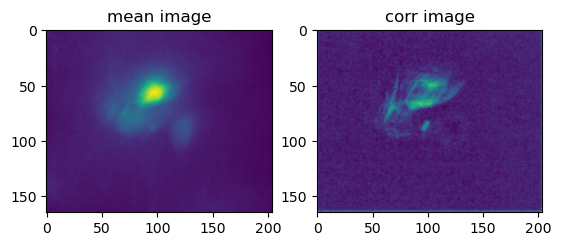

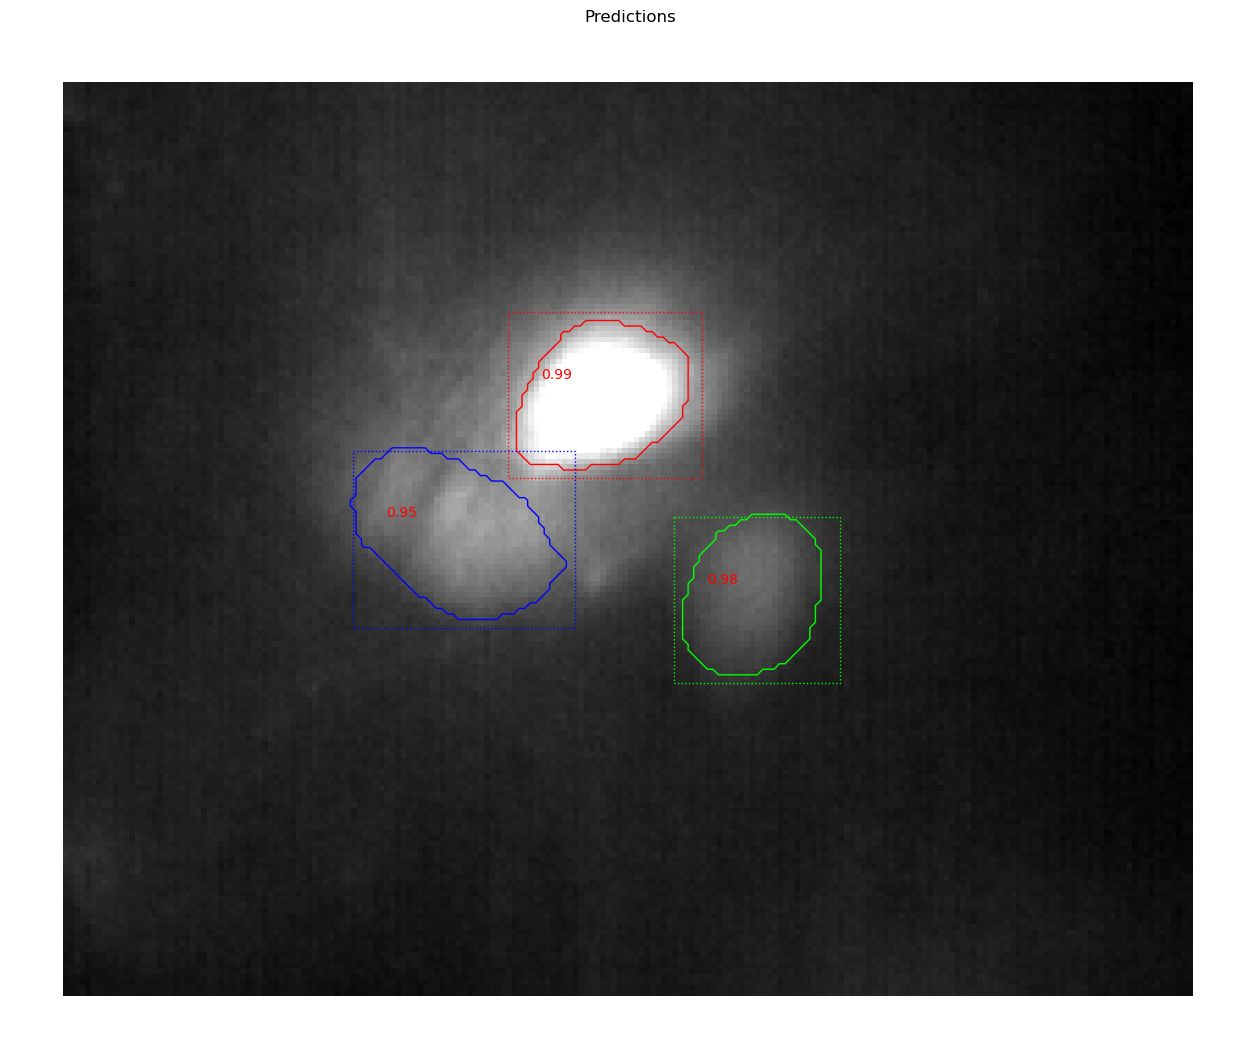

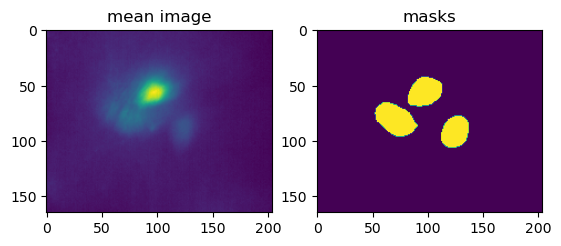

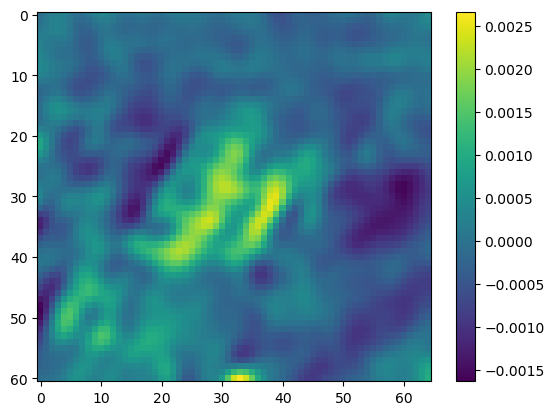

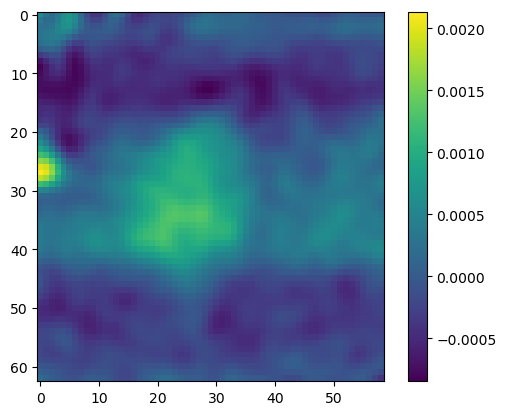

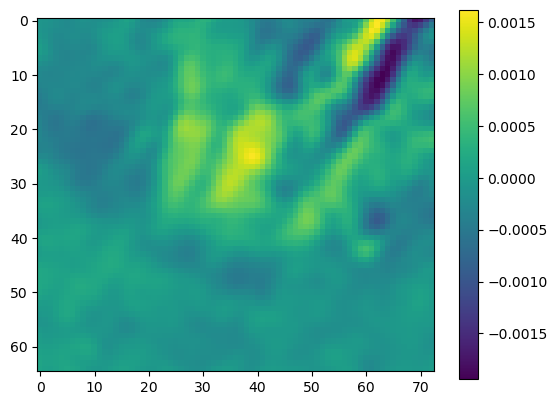

   257878317 [cluster.py:         stop_server():348][33016] stop_cluster(): done


In [6]:
# This is to mask the differences between running this demo in Spyder
# versus from the CLI
if __name__ == "__main__":
    main()

NameError: name 'file_dir' is not defined